In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib  inline
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from skimage import color
from itertools import compress
from skimage import io
train_data_dir = 'test_task/train'


## Baseline - logistic regression with greyscale images

In [2]:
X_train = []
y_train = []
X_test = []
y_test = []

for file in os.listdir(os.path.join(train_data_dir,'1 object/')):
    img = color.rgb2gray(io.imread(os.path.join(train_data_dir,'1 object/',file)))
    X_train.append(img.flatten())
    y_train.append(0)
    
for file in os.listdir(os.path.join(train_data_dir,'2 objects/')):
    img = color.rgb2gray(io.imread(os.path.join(train_data_dir,'2 objects/',file)))
    X_train.append(img.flatten())
    y_train.append(1)
    
for file in os.listdir('test_task/test/'):
    img = color.rgb2gray(io.imread(os.path.join('test_task/test/',file)))
    X_test.append(img.flatten())
    if len(file.split('_')) > 1:
        y_test.append(1)
    else:
        y_test.append(0)
        
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [3]:
clf = LogisticRegression(solver = 'liblinear')
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [4]:
pred = clf.predict(X_test)
print("Accuracy: {}".format(clf.score(X_test, y_test)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Predicted labels: \n {}".format(pred))

Accuracy: 0.5795454545454546
Confusion matrix : 
 [[60 38]
 [36 42]]
Predicted labels: 
 [1 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1
 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 1 0 0 1
 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0
 1 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1]


So, basic logistic regression without parameter tuning is as good as random guess at this task, though model doesn't predict one label to all images

## CNN

In [5]:
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping

batch_size = 16
img_height = 256
img_width = 256

Using TensorFlow backend.


In [6]:
# image generator with augmentations and split into train and validation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') 


Found 568 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


In [18]:
model = Sequential()
model.add(Conv2D(64, (3, 3),data_format='channels_last', input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten()) 
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
epochs = 10
history = model.fit_generator(
    train_generator,
    epochs = epochs,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [EarlyStopping(patience = 3, monitor = 'val_loss')])

Epoch 1/10
35/35 [==============================] - 71s 2s/step - loss: 0.9167 - acc: 0.5001 - val_loss: 0.6528 - val_acc: 0.5556
Epoch 2/10
35/35 [==============================] - 71s 2s/step - loss: 0.6608 - acc: 0.6946 - val_loss: 0.4967 - val_acc: 0.8750
Epoch 3/10
35/35 [==============================] - 71s 2s/step - loss: 0.5310 - acc: 0.7714 - val_loss: 0.9833 - val_acc: 0.5397
Epoch 4/10
35/35 [==============================] - 71s 2s/step - loss: 0.4906 - acc: 0.7857 - val_loss: 0.2811 - val_acc: 0.9048
Epoch 5/10
35/35 [==============================] - 71s 2s/step - loss: 0.4491 - acc: 0.8231 - val_loss: 0.6529 - val_acc: 0.6429
Epoch 6/10
35/35 [==============================] - 70s 2s/step - loss: 0.3673 - acc: 0.8518 - val_loss: 0.6404 - val_acc: 0.6667
Epoch 7/10
35/35 [==============================] - 70s 2s/step - loss: 0.2211 - acc: 0.9144 - val_loss: 0.2434 - val_acc: 0.9206
Epoch 8/10
35/35 [==============================] - 72s 2s/step - loss: 0.3290 - acc: 0.87

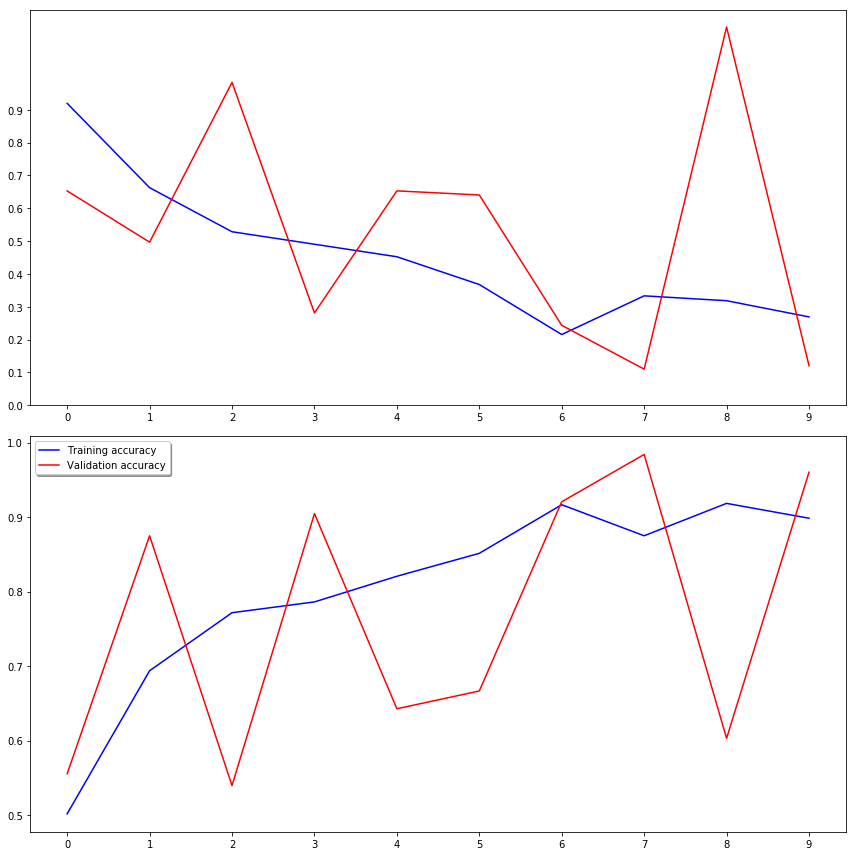

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(history.epoch)
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(history.epoch)

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [21]:
model.evaluate_generator(validation_generator,steps = validation_generator.samples // batch_size) 

[0.11823275673484045, 0.9523809523809523]

In [22]:
filenames = os.listdir("test_task/test")
categories = []
for filename in filenames:
    if len(filename.split('_')) > 1:
#         two objects
        categories.append(1)
    else:
        categories.append(0)

test_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [23]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "test_task/test", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

Found 176 images belonging to 2 classes.


In [27]:
ypred = model.predict_generator(test_generator, steps = test_generator.samples // batch_size)
ypred = np.round(ypred.flatten())
score = model.evaluate_generator(test_generator,steps = test_generator.samples // batch_size )
cf = confusion_matrix(test_generator.classes,ypred)

print("Test accuracy : {}".format(score[1]))
print("Test loss : {}".format(score[0]))
print("Confusion matrix :\n {}".format(cf))

Test accuracy : 0.9602272727272727
Test loss : 0.09532812009142204
Confusion matrix :
 [[96  2]
 [ 5 73]]


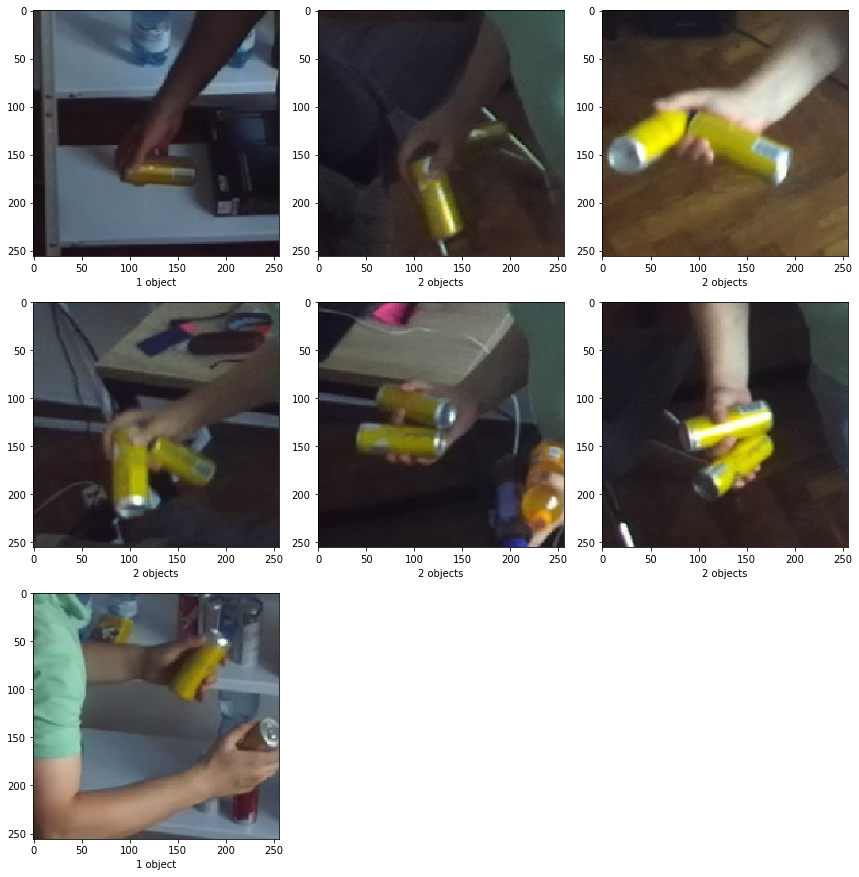

In [38]:
misclassified_images = list(compress(test_generator.filenames, ypred != test_generator.classes))
plt.figure(figsize=(12, 24))
for index, image in enumerate(misclassified_images):
    img = load_img(os.path.join("test_task/test/",image), target_size=(img_height,img_width))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    category = "2 objects" if len(image.split('_')) > 1 else "1 object"
    plt.xlabel(category)
plt.tight_layout()
plt.show()